In [39]:
# ----------------------------
# 1. Imports
# ----------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import Lasso
from sklearn import metrics
import statsmodels.api as sm


In [40]:

# ----------------------------
# 2. Load data
# ----------------------------
df_raw = pd.read_excel("Aufgabe_1_Gloss_Optimization.xlsx")
pd.set_option('display.expand_frame_repr', False)
print(f"Dataset dimensions: {df_raw.shape}")
print(df_raw.tail())

Dataset dimensions: (58, 15)
    V13    V15  V16    V18  V19    V21       V28       V29       V30       V31       V32       V33       V34  V39  gloss
53  0.2  HMW 1  0.2  HMW 6  0.0    NaN  0.217525  0.195159  0.005929  0.018465 -0.006291  0.002313  0.017525    5   4800
54  0.4  HMW 5  0.0    NaN  0.0    NaN  0.394731 -0.022175 -0.013080 -0.003039 -0.035266 -0.009641 -0.005269    5   6000
55  0.4  HMW 6  0.0    NaN  0.0    NaN  0.414315 -0.006811 -0.007612  0.012732 -0.000735 -0.001841  0.014315    5   4700
56  0.2  HMW 5  0.2  LMW 6  0.0    NaN  0.207545 -0.002715 -0.000442 -0.006795  0.000325  0.203296  0.007545    6   8000
57  0.2  HMW 1  0.1  LMW 6  0.1  LMW 1  0.011453  0.204203 -0.005749 -0.000304  0.090017  0.117056  0.011453    8   7300


In [41]:

# ----------------------------
# 3. Features / target / encoding
# ----------------------------
y = df_raw.iloc[:,-1]
X_raw = df_raw.iloc[:, :-1]

# Identify categorical columns
cat_idx = np.where(X_raw.dtypes == object)[0]

# One-hot encoding for categorical features
ct = ColumnTransformer([('encoder', OneHotEncoder(drop='first'), cat_idx)], remainder='passthrough')
X_encoded = ct.fit_transform(X_raw)
feature_names = ct.get_feature_names_out()


In [42]:

# ----------------------------
# 4. Train/Test split & scaling
# ----------------------------
rnd_state = 1
X_train_val, X_test, y_train_val, y_test = train_test_split(X_encoded, y, test_size=0.1, random_state=rnd_state, shuffle=True)

scaler = StandardScaler()
X_train_val_z = scaler.fit_transform(X_train_val)
X_test_z = scaler.transform(X_test)

In [43]:
# ----------------------------
# 5. Outlier removal (target > 11000)
# ----------------------------
mask = y_train_val < 11000
X_train_val_clean_z = X_train_val_z[mask.values, :]
y_train_val_clean = y_train_val[mask.values]

X_outliers_z = X_train_val_z[~mask.values, :]
y_outliers = y_train_val[~mask.values]


In [44]:
# Core libraries
import pandas as pd
import numpy as np

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import dates as mdates
from matplotlib.ticker import AutoMinorLocator, FormatStrFormatter

# Machine Learning tools
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Lasso, HuberRegressor
from sklearn.svm import SVR
from sklearn import metrics

# Additional utilities
import statsmodels.api as sm
from itertools import cycle
from multiprocessing import cpu_count
import copy


In [45]:

# --- Load data ---
df_raw = pd.read_excel("Aufgabe_1_Gloss_Optimization.xlsx")

# Show full width without wrapping
pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)

# Custom figure style (warm tone, larger default size)
plt.style.use("seaborn-v0_8-deep")
plt.rcParams["figure.figsize"] = (8, 5)

# Output dataset info
rows, cols = df_raw.shape
print(f'Dataset "Gloss_Optimization" dimensions: {rows} rows × {cols} columns\n')
df_raw.head(11)

Dataset "Gloss_Optimization" dimensions: 58 rows × 15 columns



,V13,V15,V16,V18,V19,V21,V28,V29,V30,V31,V32,V33,V34,V39,gloss
0,0.10,HMW 1,0.05,LMW 1,0.05,LMW 6,-0.004681,0.103880,0.000972,-0.005881,0.055534,0.058750,-0.004681,8,6200
1,0.12,HMW 1,0.04,LMW 1,0.04,LMW 6,-0.010345,0.112653,0.001479,0.005503,0.040954,0.056777,-0.010345,8,6400
2,0.12,HMW 1,0.06,LMW 1,0.02,LMW 6,-0.005359,0.125634,0.003815,-0.012599,0.074109,0.015341,-0.005359,8,5800
3,0.14,HMW 1,0.04,LMW 1,0.02,LMW 6,-0.004240,0.147946,-0.016650,0.010005,0.039433,0.018663,-0.004240,6,6200
4,0.28,HMW 1,0.08,LMW 1,0.04,LMW 6,-0.026882,0.284841,-0.009568,-0.019216,0.068883,0.038201,-0.026882,8,8600
5,0.12,HMW 1,0.06,LMW 1,0.02,LMW 7,-0.012378,0.131851,-0.009754,0.003244,0.059373,0.026450,-0.012378,8,4800
6,0.24,HMW 1,0.12,LMW 1,0.04,LMW 7,-0.003660,0.244951,0.016939,-0.012309,0.123884,0.042937,-0.003660,8,6800
7,0.14,HMW 1,0.04,LMW 1,0.02,LMW 7,0.006664,0.125695,-0.004785,-0.004625,0.037321,0.018528,0.006664,6,4000
8,0.28,HMW 1,0.08,LMW 1,0.04,LMW 7,0.018571,0.288215,-0.007519,0.003315,0.079077,0.046381,0.018571,8,6600
9,0.10,HMW 1,0.05,LMW 1,0.05,LMW 3,0.007331,0.103919,0.002864,-0.014808,0.067368,0.005788,0.007331,8,7300


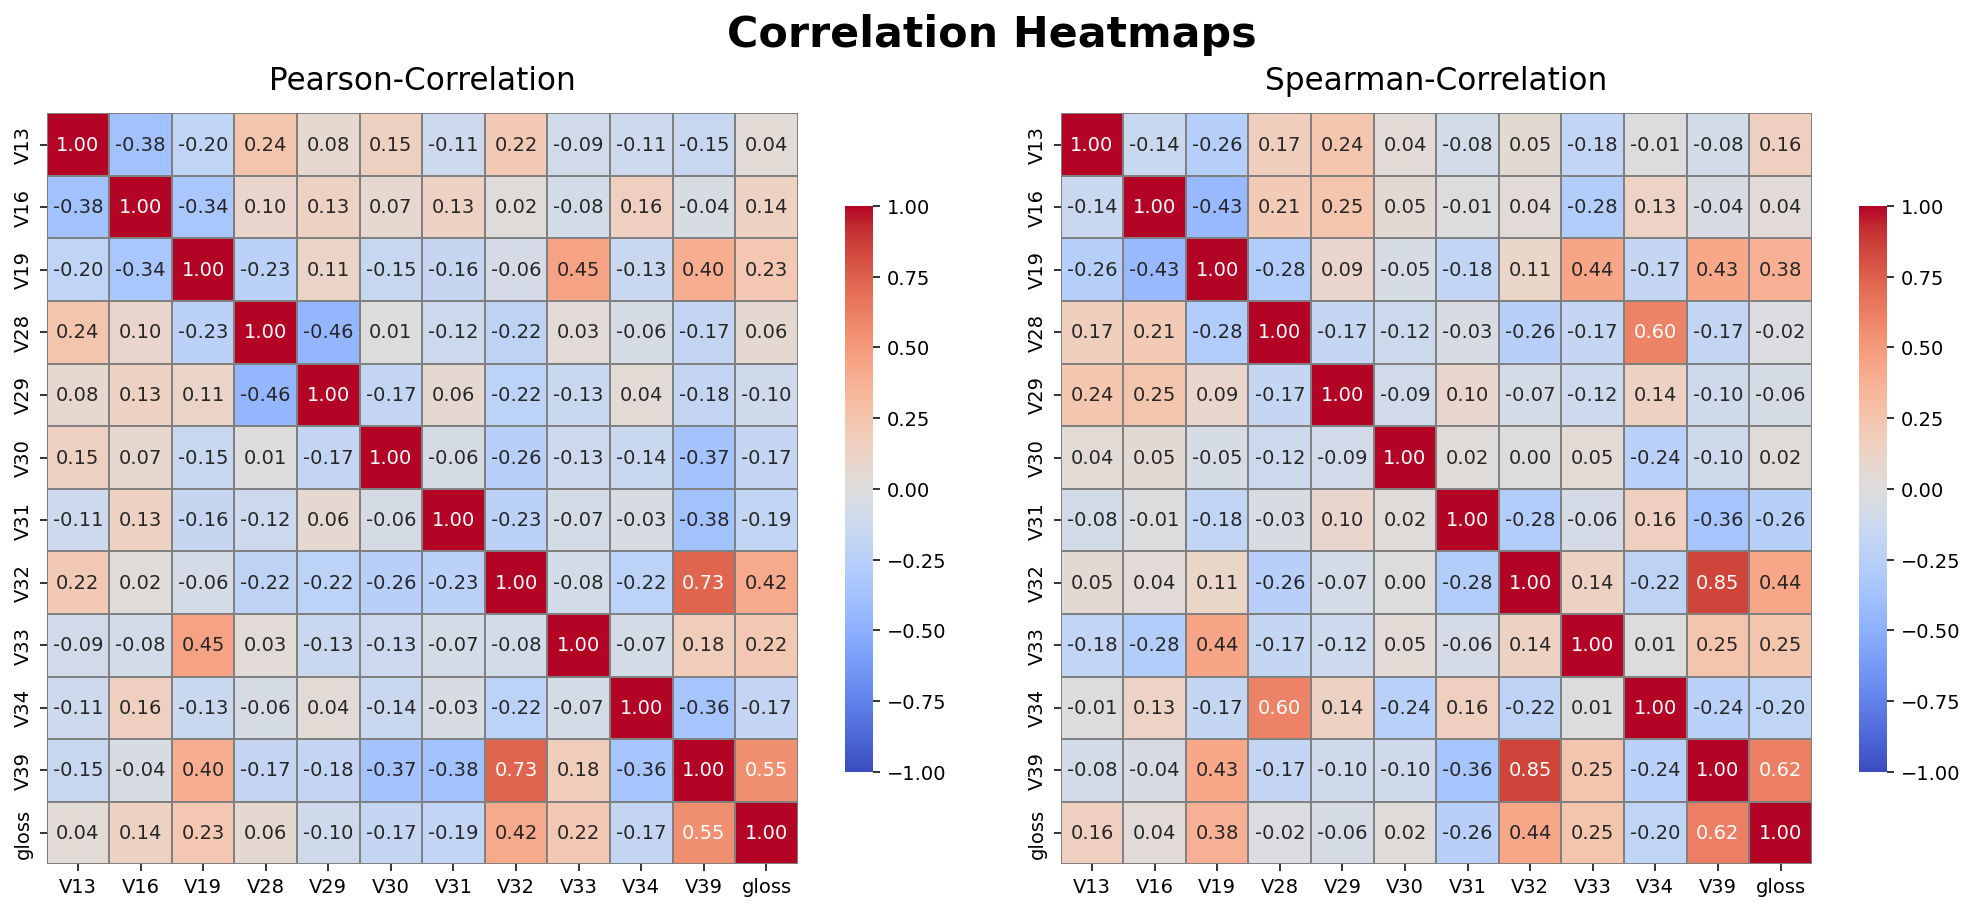

In [46]:
# --- Select numeric columns only ---
numeric_df = df_raw.select_dtypes(include=[np.number])

# --- Correlation calculation ---
methods = ["pearson", "spearman"]
correlation_matrices = {m: numeric_df.corr(method=m) for m in methods}

# --- Plot ---
fig, axes = plt.subplots(ncols=2, figsize=(18, 7), dpi=140)
fig.suptitle("Correlation Heatmaps", fontsize=22, fontweight="bold")
plt.subplots_adjust(wspace=0.08)

color_map = "coolwarm"

for ax, method in zip(axes, methods):
    sns.heatmap(
        correlation_matrices[method],
        ax=ax,
        annot=True,
        cmap=color_map,
        linewidths=0.8,
        linecolor="gray",
        fmt=".2f",
        vmin=-1,
        vmax=1,
        square=True,
        cbar_kws={"shrink": 0.75}
    )
    ax.set_title(f"{method.capitalize()}‑Correlation", fontsize=16, pad=12)

plt.show()

In [47]:
# --- Parameters ---
RANDOM_STATE = 1
TEST_RATIO = 0.10

# --- Separate target and features ---
target_col = df_raw.columns[-1]
y = df_raw[target_col]
X_raw = df_raw.drop(columns=target_col)

# --- Identify categorical (object) columns for encoding ---
cat_cols = X_raw.select_dtypes(include=["object"]).columns.tolist()

# --- One-Hot Encoding with ColumnTransformer ---
encoder = ColumnTransformer(
    transformers=[
        ("ohe", OneHotEncoder(drop="first"), cat_cols)
    ],
    remainder="passthrough"
)
X_encoded = encoder.fit_transform(X_raw)

# --- Headers for transformed data ---
X_headers = encoder.get_feature_names_out()
n_rows, n_cols = X_encoded.shape

print(f"Target (y) column:\n{target_col}\n")
print(f"Feature columns ({n_cols}):\n{np.array(X_headers)}\n")

# --- Train/Test split ---
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X_encoded, y,
    test_size=TEST_RATIO,
    random_state=RANDOM_STATE,
    shuffle=True
)

# --- Standardize based on train/val only ---
scaler = StandardScaler()
X_train_val_z = scaler.fit_transform(X_train_val)
X_test_z = scaler.transform(X_test)

# --- Outlier filtering (values < 11,000) ---
mask_inlier = y_train_val < 11000
X_train_val_z_in = X_train_val_z[mask_inlier]
X_train_val_in = X_train_val[mask_inlier]
y_train_val_in = y_train_val[mask_inlier]

X_train_val_z_out = X_train_val_z[~mask_inlier]
X_train_val_out = X_train_val[~mask_inlier]
y_train_val_out = y_train_val[~mask_inlier]

Target (y) column:
gloss

Feature columns (35):
['ohe__V15_HMW 2' 'ohe__V15_HMW 3' 'ohe__V15_HMW 4' 'ohe__V15_HMW 5'
 'ohe__V15_HMW 6' 'ohe__V15_LMW 1' 'ohe__V15_LMW 2' 'ohe__V15_LMW 3'
 'ohe__V18_HMW 3' 'ohe__V18_HMW 4' 'ohe__V18_HMW 5' 'ohe__V18_HMW 6'
 'ohe__V18_LMW 1' 'ohe__V18_LMW 2' 'ohe__V18_LMW 4' 'ohe__V18_LMW 5'
 'ohe__V18_LMW 6' 'ohe__V18_MMW 1' 'ohe__V18_MMW 2' 'ohe__V18_nan'
 'ohe__V21_LMW 3' 'ohe__V21_LMW 6' 'ohe__V21_LMW 7' 'ohe__V21_nan'
 'remainder__V13' 'remainder__V16' 'remainder__V19' 'remainder__V28'
 'remainder__V29' 'remainder__V30' 'remainder__V31' 'remainder__V32'
 'remainder__V33' 'remainder__V34' 'remainder__V39']



In [48]:
from math import floor, ceil

def compute_error_metrics(model, X_train, X_test, X_out, y_train, y_test):
    """Calculate predictions, residuals, and common regression error metrics."""
    y_pred_out = model.predict(X_out) if len(X_out) else np.nan
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    errors_train = y_train - y_pred_train
    errors_test = y_test - y_pred_test

    # Helper to compute RMSE, R², and NRMSE
    rmse = {lbl: metrics.mean_squared_error(
                y, y_hat, squared=False
            ) for lbl, y, y_hat in [
                ("TrainVal", y_train, y_pred_train),
                ("Test", y_test, y_pred_test)
            ]}

    r2 = {lbl: metrics.r2_score(y, y_hat)
          for lbl, y, y_hat in [
              ("TrainVal", y_train, y_pred_train),
              ("Test", y_test, y_pred_test)
          ]}

    nrmse = {k: 1 - np.sqrt(abs(v - 1)) for k, v in r2.items()}

    return model, y_pred_train, y_pred_test, y_pred_out, errors_train, errors_test, {
        "RMSE": rmse,
        "NRMSE": nrmse,
        "R2": r2
    }

def plot_results(title, y_train, y_test, y_out, y_pred_train, y_pred_test, y_pred_out, err_train, err_test):
    """Visualize predicted vs actual, error histograms, and residuals over index."""
    # Determine min/max range rounded to nearest 1000
    valid_vals = [y_train, y_pred_train, y_test, y_pred_test]
    if np.size(y_out) > 0 and not np.isnan(np.sum(y_out)):
        valid_vals.extend([y_pred_out, y_out])
    y_min = floor(np.min([np.min(v) for v in valid_vals]) / 1000) * 1000
    y_max = ceil(np.max([np.max(v) for v in valid_vals]) / 1000) * 1000

    fig, axes = plt.subplots(1, 3, figsize=(11, 3), dpi=150)
    fig.suptitle(title, fontsize=14, fontweight="bold")

    # Scatter: predicted vs actual
    axes[0].plot([y_min, y_max], [y_min, y_max], color="black", lw=0.8)
    axes[0].scatter(y_train, y_pred_train, alpha=0.6, label="Train+Val", s=15)
    axes[0].scatter(y_test, y_pred_test, alpha=0.6, label="Test", s=15)
    if np.size(y_out) > 1 and not np.isnan(np.sum(y_out)):
        axes[0].scatter(y_out, y_pred_out, alpha=0.5, label="Removed Outliers", color="crimson", s=15)
    axes[0].set(xlabel="Measurement", ylabel="Model", xlim=(y_min, y_max), ylim=(y_min, y_max))
    axes[0].legend(fontsize=6, loc="upper left")

    # Histogram of errors
    axes[1].hist(err_train, density=True, bins="auto", label="Train+Val", alpha=0.7)
    axes[1].hist(err_test, density=True, bins="auto", label="Test", alpha=0.5)
    axes[1].set(xlabel="Residual", ylabel="Relative Frequency")
    axes[1].legend(fontsize=6, loc="upper left")

    # Residuals over index
    axes[2].scatter(y_train.index, err_train, s=10, label="Train+Val")
    axes[2].scatter(y_test.index, err_test, s=10, label="Test")
    axes[2].set(xlabel="Index", ylabel="y - ŷ")
    axes[2].legend(fontsize=6, loc="upper left")

    plt.tight_layout()
    plt.show()

In [49]:
def compute_error_metrics(model, X_train, X_test, X_out, y_train, y_test):
    """Calculate predictions, residuals, and common regression error metrics."""
    # Predictions
    y_pred_out = model.predict(X_out) if len(X_out) else np.nan
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    # Residuals
    errors_train = y_train - y_pred_train
    errors_test = y_test - y_pred_test

    # RMSE (manual sqrt to avoid 'squared' param issues)
    rmse = {
        lbl: np.sqrt(metrics.mean_squared_error(y, y_hat))
        for lbl, y, y_hat in [
            ("TrVal", y_train, y_pred_train),
            ("Test", y_test, y_pred_test)
        ]
    }

    # R²
    r2 = {
        lbl: metrics.r2_score(y, y_hat)
        for lbl, y, y_hat in [
            ("TrVal", y_train, y_pred_train),
            ("Test", y_test, y_pred_test)
        ]
    }

    # NRMSE
    nrmse = {
        lbl: 1 - np.sqrt(abs(r2_val - 1))
        for lbl, r2_val in [
            ("TrVal", r2["TrVal"]),
            ("Test", r2["Test"])
        ]
    }

    return model, y_pred_train, y_pred_test, y_pred_out, errors_train, errors_test, {
        "RMSE": rmse,
        "NRMSE": nrmse,
        "R2": r2
    }

In [50]:

def run_lasso_cv(X_train_val, y_train_val, random_state=42):
    """
    Perform Lasso regression with a range of alpha values using K-Fold cross-validation.
    Returns:
        alphas_lasso, coefs_lasso, rmse_tr_mean, rmse_tr_std, rmse_val_mean, rmse_val_std,
        optimal_alpha, n_features_selected
    """

    # Search space for alpha values
    a_min = 0
    a_max = np.log10(1000)
    alphas_lasso = np.logspace(a_min, a_max, int(np.ceil(a_max * 100 + 1)))

    kf = KFold(n_splits=5, shuffle=True, random_state=random_state)

    # Tracking results
    coefs_lasso     = []
    rmse_tr_mean    = []
    rmse_tr_std     = []
    rmse_val_mean   = []
    rmse_val_std    = []
    r2_tr_mean      = []
    r2_tr_std       = []
    r2_val_mean     = []
    r2_val_std      = []
    nrmse_tr_mean   = []
    nrmse_tr_std    = []
    nrmse_val_mean  = []
    nrmse_val_std   = []

    for alpha in alphas_lasso:
        rmse_tr, rmse_val = [], []
        r2_tr, r2_val     = [], []
        nrmse_tr, nrmse_val = [], []
        temp_coef         = []

        for idx_train, idx_val in kf.split(X_train_val):
            # Split fold
            X_tr, X_val = X_train_val[idx_train, :], X_train_val[idx_val, :]
            y_tr = y_train_val.iloc[idx_train]
            y_val = y_train_val.iloc[idx_val]

            # Fit Lasso
            clf = Lasso(alpha=alpha, max_iter=10000)
            clf.fit(X_tr, y_tr)

            # Predict
            y_pred_tr = clf.predict(X_tr)
            y_pred_val = clf.predict(X_val)

            # Store coefficients
            temp_coef.append(clf.coef_)

            # Metrics
            rmse_tr.append(metrics.mean_squared_error(y_tr, y_pred_tr, squared=False))
            rmse_val.append(metrics.mean_squared_error(y_val, y_pred_val, squared=False))
            r2_tr.append(metrics.r2_score(y_tr, y_pred_tr))
            r2_val.append(metrics.r2_score(y_val, y_pred_val))
            nrmse_tr.append(1 - np.sqrt(abs(r2_tr[-1] - 1)))
            nrmse_val.append(1 - np.sqrt(abs(r2_val[-1] - 1)))

        # Store fold-averaged metrics
        rmse_tr_mean.append(np.mean(rmse_tr))
        rmse_tr_std.append(np.std(rmse_tr, ddof=1))
        rmse_val_mean.append(np.mean(rmse_val))
        rmse_val_std.append(np.std(rmse_val, ddof=1))
        r2_tr_mean.append(np.mean(r2_tr))
        r2_tr_std.append(np.std(r2_tr, ddof=1))
        r2_val_mean.append(np.mean(r2_val))
        r2_val_std.append(np.std(r2_val, ddof=1))
        nrmse_tr_mean.append(np.mean(nrmse_tr))
        nrmse_tr_std.append(np.std(nrmse_tr, ddof=1))
        nrmse_val_mean.append(np.mean(nrmse_val))
        nrmse_val_std.append(np.std(nrmse_val, ddof=1))
        coefs_lasso.append(np.mean(np.array(temp_coef), axis=0))

    coefs_lasso = np.array(coefs_lasso)

    # Select optimal alpha within tolerance
    error_tolerance_pct = 5
    val_rmse_min = np.min(rmse_val_mean)
    idx_best_rmse = np.where(rmse_val_mean == val_rmse_min)[0][-1]

    val_rmse_diff = abs(np.array(rmse_val_mean[idx_best_rmse:]) -
                        val_rmse_min * (1 + error_tolerance_pct / 100))
    idx_tol = np.where(val_rmse_diff == np.min(val_rmse_diff))[0][-1]

    idx_optimal = idx_best_rmse + idx_tol
    optimal_alpha = alphas_lasso[idx_optimal]
    n_features_selected = np.sum(coefs_lasso[idx_optimal, :] != 0)

    return (alphas_lasso, coefs_lasso, rmse_tr_mean, rmse_tr_std,
            rmse_val_mean, rmse_val_std, optimal_alpha, n_features_selected)



In [ ]:


alphas, coefs, rmse_tr_m, rmse_tr_s, rmse_val_m, rmse_val_s, alpha_with, n_feat_with = run_lasso_cv(X_TrVal_z, y_TrVal)
alphas, coefs, rmse_tr_m, rmse_tr_s, rmse_val_m, rmse_val_s, alpha_without, n_feat_without = run_lasso_cv(X_TrVal_z_woo, y_TrVal_woo)

# --- Fit final models ---
lasso_with    = Lasso(alpha=alpha_without, max_iter=10000).fit(X_TrVal_z, y_TrVal)
lasso_without = Lasso(alpha=alpha_with, max_iter=10000).fit(X_TrVal_z_woo, y_TrVal_woo)

# --- Evaluate ---
_, ypred_train_with, ypred_test_with, _, err_train_with, err_test_with, metrics_with = \
    fcnl_error(lasso_with, X_TrVal_z, X_T_z, [], y_TrVal, y_T)

_, ypred_train_without, ypred_test_without, ypred_out_without, err_train_without, err_test_without, metrics_without = \
    fcnl_error(lasso_without, X_TrVal_z_woo, X_T_z, X_o_z, y_TrVal_woo, y_T)

# --- Print Summary ---
print('\n\n{:>23} | {:>9} | {:>9} | {:>13} | {:>13} | {:>14} | {:>14} | {}'.format(
    "Num. Params", "R² (Train+Val)", "R² (Test)", "RMSE (Train+Val)",
    "RMSE (Test)", "NRMSE (Train+Val)", "NRMSE (Test)", "Comment"
))
fcnl_print('OLS', n_ols_wo, ols_err_wo, 'Highest p-value feature removed, with outlier')
fcnl_print('OLS', n_ols_woo, ols_err_woo, 'Highest p-value feature removed, without outlier')
fcnl_print('Lasso', n_feat_with, metrics_with, 'with outlier')
fcnl_print('Lasso', n_feat_without, metrics_without, 'without outlier')

# --- Plots ---
fcnl_plot('Lasso Regression (with outlier)',
          y_TrVal, y_T, [], ypred_train_with, ypred_test_with, [],
          err_train_with, err_test_with)

fcnl_plot('Lasso Regression (without outlier)',
          y_TrVal_woo, y_T, y_TrVal_o, ypred_train_without, ypred_test_without,
          ypred_out_without, err_train_without, err_test_without)

NameError: name 'X_train_val_wo' is not defined